## Linear regression model for car price forecasting

Importing all necessary modules

In [211]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools as it

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce


import seaborn as sns
sns.set()

Importing dataset. We can observe that there are numeric and categorical columns. So we'll further need to encode categorical ones to use them in our model.

In [212]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


Summary statistics show that there are some missing values and possible outliers.

In [213]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Remove missing values from target. We still have ones in the column EngineV.

In [214]:
data.dropna(subset=['Price'],axis=0,inplace=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4173.000000,4025.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,164.088426,2.764586,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,104.823056,4.935941,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


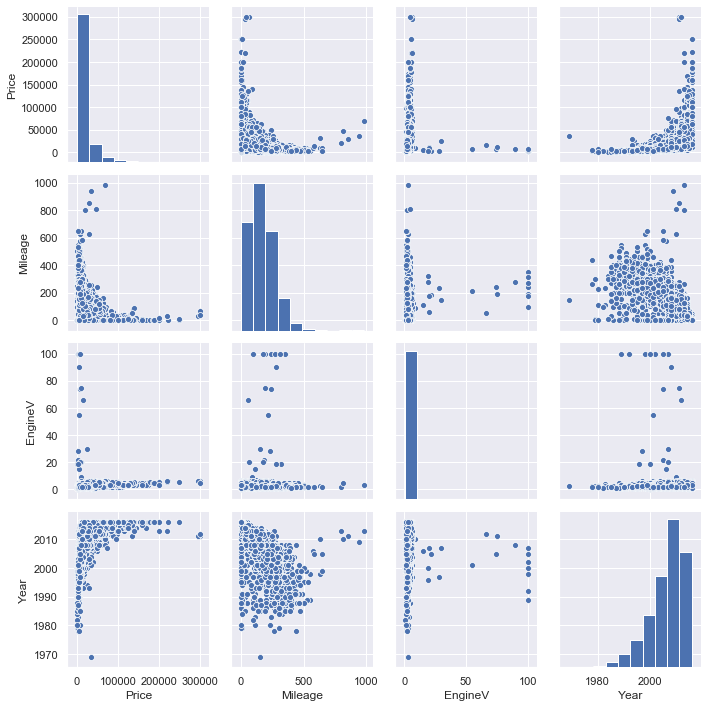

In [215]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

Based on the charts above we can visually identify outliers and remove them too. Also we can see that relationship between target and features is not linear. So we'll need to transform our data before try to apply linear regression.

In [216]:
data=data[data['EngineV']<6.5]
data=data[data['EngineV']>=1]
data=data[data['Year']>1970]
data=data[data['Mileage']<700]
data=data[data['Price']<150000]
data.describe(include='all')


,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3967,3967.000000,3967,3967.000000,3967.000000,3967,3967,3967.000000,3967
unique,7,NaN,6,NaN,NaN,4,2,NaN,300
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,874,NaN,1518,NaN,NaN,1848,3602,NaN,188
mean,NaN,18220.144936,NaN,164.039577,2.448571,NaN,NaN,2006.338039,NaN
std,NaN,20042.680314,NaN,101.206595,0.948775,NaN,NaN,6.654080,NaN
min,NaN,600.000000,NaN,0.000000,1.000000,NaN,NaN,1978.000000,NaN
25%,NaN,6999.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,159.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21500.000000,NaN,230.000000,3.000000,NaN,NaN,2011.500000,NaN


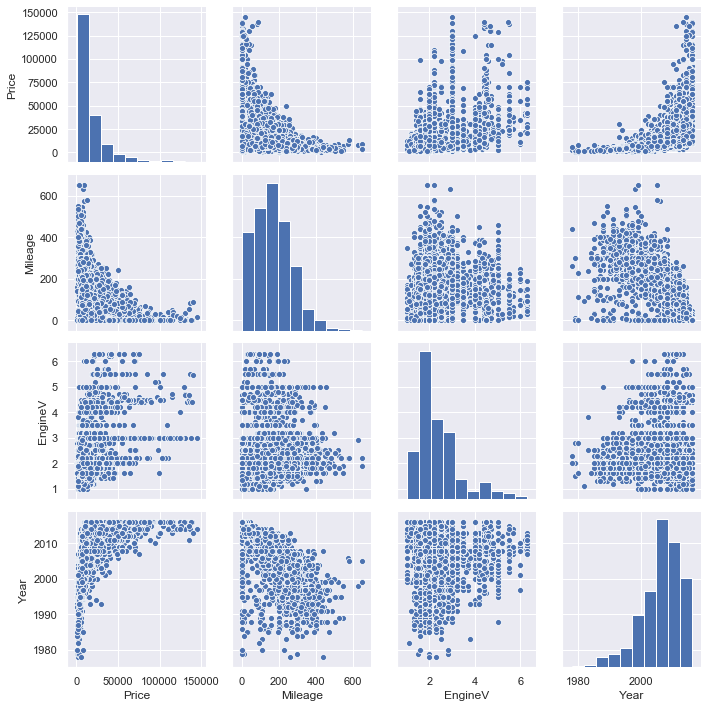

In [217]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

In [218]:
data['Model_Year']=data['Model']+'_'+data['Year'].astype('str')

model_quantity=data.sort_values(by=['Model','Year']).groupby('Model_Year').count()
model_quantity=model_quantity.iloc[:,1].rename('Model_quantity')

data=data.join(model_quantity, on='Model_Year')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Model_Year,Model_quantity
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,320_1991,2
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,Sprinter 212_1999,2
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,S 500_2003,2
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,Q7_2007,17
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,Rav 4_2011,6


In [219]:
new_min=data.groupby('Model')[['Year']].min()
new_min=new_min.rename(columns={"Year":"Min_year"})
data=data.join(new_min, on='Model')
data['Oldness']=data['Year']-data['Min_year']
data=data.drop(['Model_Year','Min_year'],axis=1)
data.head()




,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Model_quantity,Oldness
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,2,5
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,2,2
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,2,7
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,17,1
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,6,12


In [220]:
# cet=ce.TargetEncoder()
# data['Year']=cet.fit_transform(data['Year'].astype('str'), data['Price'])
# print(data['Year'].head())

In [221]:
variables = data[['Mileage','EngineV','Oldness','Model_quantity','Year']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,3.712914,Mileage
1,7.826727,EngineV
2,2.486826,Oldness
3,2.268754,Model_quantity
4,14.536059,Year


In [222]:
data['Year'].astype('str')


cat_features = ['Brand', 'Model', 'Body', 'Engine Type', 'Year']

# Iterate through each pair of features, combine them into interaction features
name=""
for item in it.combinations(cat_features, 2):
    name=item[0]+"_"+item[1]
    data[name]=data[item[0]].astype('str')+"_"+data[item[1]].astype('str')

data=data.rename(columns={'Year':'Avg_price_in_year'})

In [223]:
# data.drop('Year',axis=1,inplace=True)


data['Price']= np.log(data['Price'])

In [224]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Avg_price_in_year,Model,Model_quantity,...,Brand_Model,Brand_Body,Brand_Engine Type,Brand_Year,Model_Body,Model_Engine Type,Model_Year,Body_Engine Type,Body_Year,Engine Type_Year
count,3967,3967.000000,3967,3967.000000,3967.000000,3967,3967,3967.000000,3967,3967.000000,...,3967,3967,3967,3967,3967,3967,3967,3967,3967,3967
unique,7,NaN,6,NaN,NaN,4,2,NaN,300,NaN,...,301,41,28,224,497,555,1403,24,186,130
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class,NaN,...,Mercedes-Benz_E-Class,BMW_sedan,Volkswagen_Diesel,Volkswagen_2012,E-Class_sedan,Vito_Diesel,Kangoo_2012,sedan_Petrol,sedan_2007,Diesel_2012
freq,874,NaN,1518,NaN,NaN,1848,3602,NaN,188,NaN,...,188,359,497,98,159,149,33,771,132,200
mean,NaN,9.391528,NaN,164.039577,2.448571,NaN,NaN,2006.338039,NaN,6.666247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.904247,NaN,101.206595,0.948775,NaN,NaN,6.654080,NaN,6.240598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,6.396930,NaN,0.000000,1.000000,NaN,NaN,1978.000000,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,8.853523,NaN,92.000000,1.800000,NaN,NaN,2003.000000,NaN,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,9.350102,NaN,159.000000,2.200000,NaN,NaN,2007.000000,NaN,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,9.975808,NaN,230.000000,3.000000,NaN,NaN,2011.500000,NaN,9.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


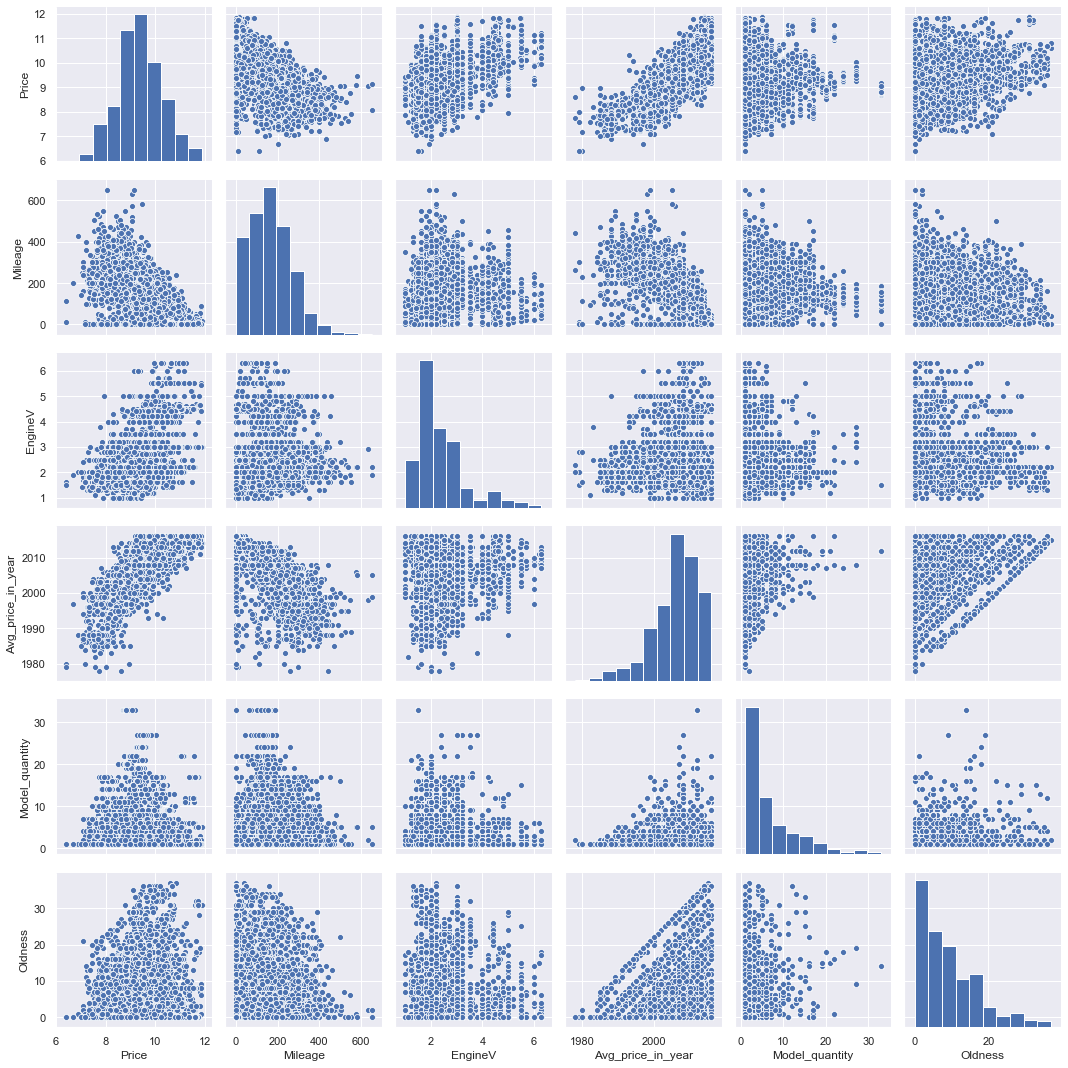

In [225]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

In [226]:
y=data.Price
X=data.drop('Price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [227]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

big_categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() >= 10 and 
                        X_train[cname].dtype == "object"]

print(categorical_cols)
print(big_categorical_cols)

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

print(numerical_cols)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

big_categorical_transformer=ce.TargetEncoder()


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('big_cat',big_categorical_transformer, big_categorical_cols)
    ])

['Brand', 'Body', 'Engine Type', 'Registration']
['Model', 'Brand_Model', 'Brand_Body', 'Brand_Engine Type', 'Brand_Year', 'Model_Body', 'Model_Engine Type', 'Model_Year', 'Body_Engine Type', 'Body_Year', 'Engine Type_Year']
['Mileage', 'EngineV', 'Avg_price_in_year', 'Model_quantity', 'Oldness']


In [228]:
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
score = mean_absolute_error(np.exp(y_test), np.exp(preds))
R2=r2_score(np.exp(y_test), np.exp(preds))
adj_R2=1-(1-R2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)

predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
y_test = y_test.reset_index(drop=True)
predictions['Target']=np.exp(y_test)
predictions['Residuals']=predictions['Target']-predictions['Prediction']
predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
MAPE=np.absolute(predictions['Residuals'].sum()/predictions['Target'].sum()*100)



print('R2:',R2.round(decimals=3))
print('adj_R2:',adj_R2.round(decimals=3))
print('MAE:', score.round(decimals=3))
print('MAPE:', MAPE.round(decimals=3))
# print(predictions.sort_values(by=['Difference%']).tail(30))




R2: 0.819
adj_R2: 0.814
MAE: 4009.622
MAPE: 6.99


In [229]:
print(predictions.sort_values(by=['Difference%']).tail(10))
predictions.describe()

       Prediction  Target     Residuals  Difference%
327   3446.991445  1550.0  -1896.991445   122.386545
58   11988.412282  5000.0  -6988.412282   139.768246
718   3497.587133  1450.0  -2047.587133   141.212906
358  15963.947593  6500.0  -9463.947593   145.599194
84    5183.391544  2100.0  -3083.391544   146.828169
356   3664.391202  1350.0  -2314.391202   171.436385
667   7025.284564  2400.0  -4625.284564   192.720190
120   4536.566573  1100.0  -3436.566573   312.415143
210  17334.425431  4000.0 -13334.425431   333.360636
679  27356.749874  5500.0 -21856.749874   397.395452


,Prediction,Target,Residuals,Difference%
count,794.000000,794.000000,794.000000,794.000000
mean,17187.780587,18479.522065,1291.741478,23.017144
std,15849.733374,20267.060012,8522.353165,29.236185
min,1550.682524,1100.000000,-21856.749874,0.099903
25%,7044.799640,6800.000000,-1803.571959,8.014946
50%,12596.177448,11925.000000,-161.645064,17.133395
75%,21009.370580,21775.000000,1759.676040,29.169582
max,107307.175447,144900.000000,78775.870079,397.395452


Text(0, 0.5, 'Residuals')

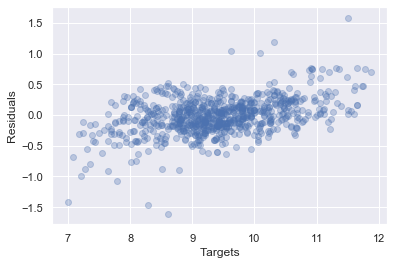

In [230]:
plt.scatter(y_test,y_test-preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Residuals',size=12)

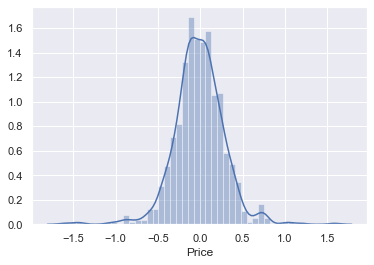

In [231]:
sns.distplot(y_test-preds)

(6.5, 12)

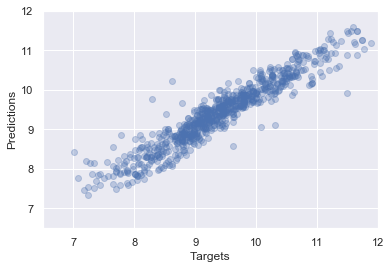

In [232]:

plt.scatter(y_test,preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Predictions',size=12)
plt.xlim(6.5,12)
plt.ylim(6.5,12)


In [233]:
scores=cross_val_score(my_pipeline, X, y, cv=5)
print('Accuracy:',scores.mean().round(decimals=3))

Accuracy: 0.904


In [234]:
X_train_OLS=X_train
y_train_OLS=y_train

X_train_OLS[numerical_cols]=numerical_transformer.fit_transform(X_train[numerical_cols])
X_train_OLS[big_categorical_cols]=big_categorical_transformer.fit_transform(X_train[big_categorical_cols],y_train)
X_train_OLS=pd.get_dummies(X_train_OLS, drop_first=True)


X = sm.add_constant(X_train_OLS)
model_2 = sm.OLS(np.array(y_train_OLS),X)
results = model_2.fit()
results.summary()

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
G:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
G:\Anaconda\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1218.
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:41:27   Log-Likelihood:                -105.28
No. Observations:                3173   AIC:                             274.6
Df Residuals:                    3141   BIC:                             468.6
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3577      0.565      2.401      0.016       0.249       2.466
Mileage                -0.0273      0.007     -3.805      0.000      -0.041      -0.013
EngineV                 0.1751      0.006     27.147      0.000       0.162       0.188
Avg_price_in_year       0.2725      0.015     17.944      0.000       0.243       0.302
Model                  -0.0597      0.310     -0.193      0.847      -0.667       0.547
Model_quantity         -0.0294      0.005     -5.922      0.000      -0.039      -0.020
Oldness                 0.0127      0.006      2.046      0.041       0.001       0.025
Brand_Model             0.0344      0.308      0.112      0.911      -0.569       0.638
Brand_Body              0.0434      0.030      1.465      0.143      -0.015       0.101
Brand_Engine Type       0.0181      0.027      0.661      0.508      -0.036       0.072
Brand_Year              0.1726      0.021      8.064      0.000       0.131       0.215
Model_Body              0.0824      0.027      3.082      0.002       0.030       0.135
Model_Engine Type       0.1362      0.020      6.763      0.000       0.097       0.176
Model_Year              0.1432      0.013     10.947      0.000       0.118       0.169
Body_Engine Type        0.0437      0.042      1.034      0.301      -0.039       0.127
Body_Year               0.1936      0.024      7.905      0.000       0.146       0.242
Engine Type_Year       -0.0069      0.025     -0.282      0.778      -0.055       0.041
Brand_BMW              -0.0108      0.020     -0.539      0.590      -0.050       0.028
Brand_Mercedes-Benz    -0.0881      0.020     -4.377      0.000      -0.128      -0.049
Brand_Mitsubishi       -0.2742      0.027    -10.195      0.000      -0.327      -0.221
Brand_Renault          -0.3501      0.030    -11.829      0.000      -0.408      -0.292
Brand_Toyota           -0.2427      0.025     -9.733      0.000      -0.292      -0.194
Brand_Volkswagen       -0.1535      0.020     -7.774      0.000      -0.192      -0.115
Body_hatch              0.0837      0.069      1.221      0.222      -0.051       0.218
Body_other              0.0383      0.042      0.908      0.364      -0.044       0.121
Body_sedan              0.0734      0.052      1.415      0.157      -0.028       0.175
Body_vagon              0.1495      0.067      2.241      0.025       0.019       0.280
Body_van                0.0290      0.056      0.514      0.608      -0.082       0.140
Engine Type_Gas        -0.0228      0.023     -0.989      0.323      -0.068       0.022
Engine Type_Other      -0.0676      0.031     -2.152      0.031      -0.129      -0.006
Engine Type_Petrol     -0.0923      0.013     -7.214      0.000      -0.117      -0.067
Registration_yes        0.6972      0.018     39.332      0.000       0.662       0.732
===

In [235]:
variables = X_train_OLS[['Mileage','EngineV','Oldness','Model_quantity','Avg_price_in_year']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1.872719,Mileage
1,1.028360,EngineV
2,1.140300,Oldness
3,1.093417,Model_quantity
4,2.026266,Avg_price_in_year
